# Setup

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns

# Read CSV file

In [62]:
df = pd.read_csv('data.csv')
print(df.shape)
df.head(df.shape[0])

(500, 3)


,X1,X2,Y
0,340,485,0
1,440,399,0
2,216,164,1
3,498,58,0
4,498,12,0
...,...,...,...
495,112,15,2
496,359,384,0
497,253,124,1
498,349,215,0


In [63]:
# a function for 1-hot encoding the output labels

def normalize(input):
  if input == 0:
    return [1,0,0]
  elif input == 1:
    return [0,1,0]
  elif input == 2:
    return [0,0,1]
  else:
    return [0, 0, 0]

In [64]:
X1 = df["X1"].values.tolist()
X2 = df["X2"].values.tolist()
Y = df["Y"].values.tolist()

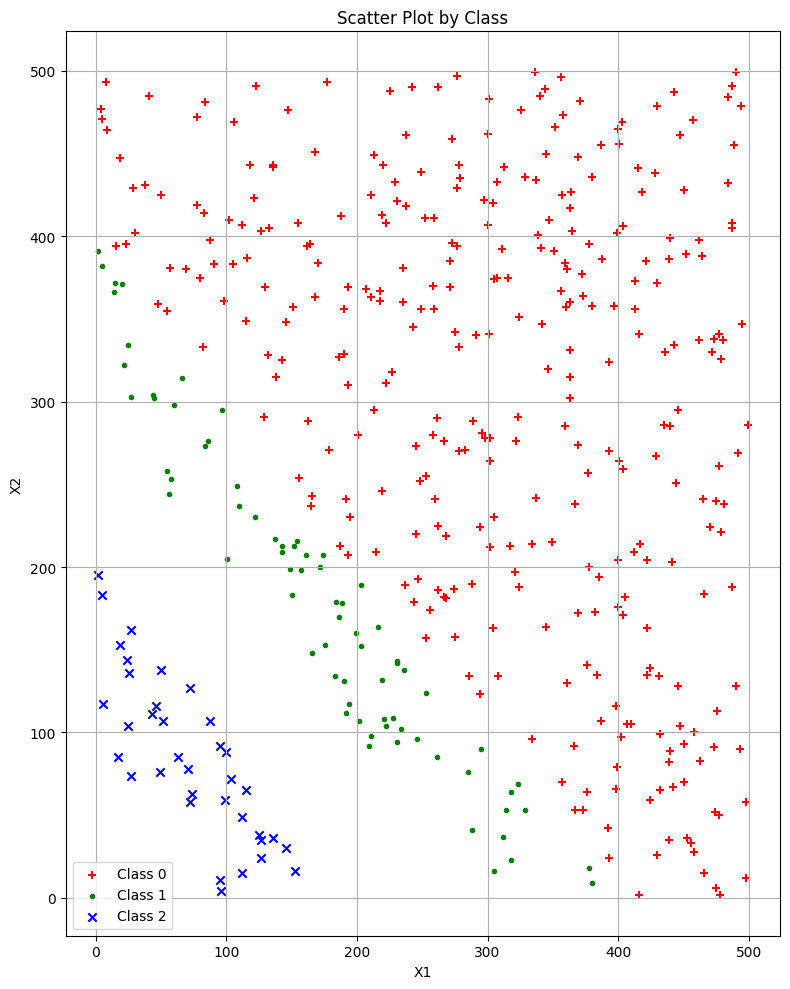

In [77]:
plt.figure(figsize=(8,10))

# Convert X1, X2 to NumPy arrays if they aren't already
X1 = np.array(X1)
X2 = np.array(X2)
Y = np.array(Y)

plt.scatter(X1[Y==0], X2[Y==0], color='red', marker='+', label='Class 0')
plt.scatter(X1[Y==1], X2[Y==1], color='green', marker='.', label='Class 1')
plt.scatter(X1[Y==2], X2[Y==2], color='blue', marker='x', label='Class 2')

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Scatter Plot by Class')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [66]:
features = list(zip(X1, X2)) #zipping the 2 input features into a list

features_np = np.array(features) #converting the list into a numpy array

In [67]:
 # normalizing the output labels to be one-hot encoded and
 # turning it into a numpy array

Y2 = np.array([normalize(i) for i in Y])

In [68]:
# dividing the total set into training (300) & testing (100) sets

features_train = features_np[:300]
Y2_train = Y2[:300]

features_test = features_np[300:]
Y2_test = Y2[300:]

# Neural Network - Training & testing

In [69]:
class NeuralNetwork(object):
    def __init__(self, inputLayerNeurons = 2, hidden1LayerNeurons = 20, hidden2LayerNeurons = 20, hidden3LayerNeurons = 20, outLayerNeurons = 3, learning_rate = 0.001, activation_type: str = 'sigmoid'):

        self.activation_type = activation_type
        self.learning_rate = learning_rate

        # random weight initialization
        self.W_H1I = np.random.randn(inputLayerNeurons, hidden1LayerNeurons)
        self.W_H2H1 = np.random.randn(hidden1LayerNeurons, hidden2LayerNeurons)
        self.W_H3H2 = np.random.randn(hidden2LayerNeurons, hidden3LayerNeurons)
        self.W_OH3 = np.random.randn(hidden3LayerNeurons, outLayerNeurons)

        # random bias initialization
        self.biases = [
            np.random.randn(hidden1LayerNeurons),
            np.random.randn(hidden2LayerNeurons),
            np.random.randn(hidden3LayerNeurons),
            np.random.randn(outLayerNeurons)
        ]

    def activation(self, x, der=False):
        if self.activation_type == 'sigmoid':
            if der == True:
                return np.exp(-x) / (1 + np.exp(-x))**2 # return x * (1-x)
            else:
                return 1 / (1 + np.exp(-x)) # 1 / (1 + e^-x)

        if self.activation_type == "tanh":
            if der == True:
                return 1 - (np.tanh(x))**2 # 1 - (tanh(x))^2
            else:
                return np.tanh(x)

        if self.activation_type == "relu":
            if der == True:
                return np.where(x > 0, 1, 0)
            else:
                return np.maximum(0, x)

        if self.activation_type == "gaussian":
            if der == True:
                return -(2 * x * np.exp(-x**2)) # -2xe^(-x^2)
            else:
                return np.exp(-x**2)  # e^(-x^2)

    def feedForward(self, X):
        hidden1_input = np.dot(X, self.W_H1I) + self.biases[0]
        self.hidden1_output = self.activation(hidden1_input)

        hidden2_input = np.dot(self.hidden1_output, self.W_H2H1) + self.biases[1]
        self.hidden2_output = self.activation(hidden2_input)

        hidden3_input = np.dot(self.hidden2_output, self.W_H3H2) + self.biases[2]
        self.hidden3_output = self.activation(hidden3_input)

        output_input = np.dot(self.hidden3_output, self.W_OH3) + self.biases[3]
        pred = self.activation(output_input)
        return pred

    def backPropagation(self, X, Y, pred):
        output_error = Y - pred
        output_delta = self.learning_rate * output_error * self.activation(pred, der=True)

        hidden3_error = output_delta.dot(self.W_OH3.T)
        hidden3_delta = self.learning_rate * hidden3_error * self.activation(self.hidden3_output, der=True)

        hidden2_error = hidden3_delta.dot(self.W_H3H2.T)
        hidden2_delta = self.learning_rate * hidden2_error * self.activation(self.hidden2_output, der=True)

        hidden1_error = hidden2_delta.dot(self.W_H2H1.T)
        hidden1_delta = self.learning_rate * hidden1_error * self.activation(self.hidden1_output, der=True)

        self.W_H1I += X.T.dot(hidden1_delta)
        self.W_H2H1 += self.hidden1_output.T.dot(hidden2_delta)
        self.W_H3H2 += self.hidden2_output.T.dot(hidden3_delta)
        self.W_OH3 += self.hidden3_output.T.dot(output_delta)

        self.biases[0] += self.learning_rate * np.sum(hidden1_delta, axis=0)
        self.biases[1] += self.learning_rate * np.sum(hidden2_delta, axis=0)
        self.biases[2] += self.learning_rate * np.sum(hidden3_delta, axis=0)
        self.biases[3] += self.learning_rate * np.sum(output_delta, axis=0)

    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X,Y,output)


<ipython-input-69-6b343e2154c6>:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x)) # 1 / (1 + e^-x)


Epoch: 0, error: 0.15158595011407927
Epoch: 10000, error: 0.1384825256159866
Epoch: 20000, error: 0.13794803144704643
Epoch: 30000, error: 0.13776086823242872
Epoch: 40000, error: 0.13767628070253182
Epoch: 50000, error: 0.13762897681515043
Epoch: 60000, error: 0.13759700915503434
Epoch: 70000, error: 0.13757197189807366
Epoch: 80000, error: 0.13755033546323947
Epoch: 90000, error: 0.13753050614485535


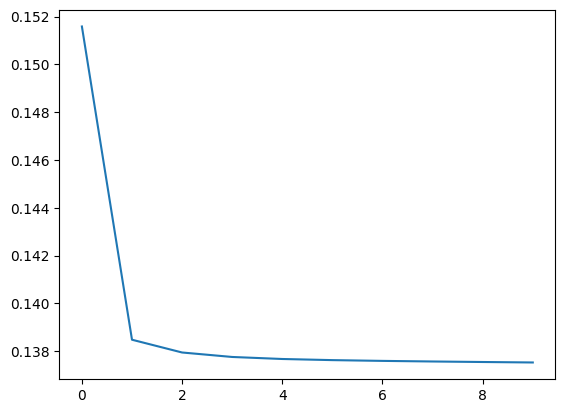

In [70]:
NN = NeuralNetwork(activation_type = 'sigmoid')
#NN = NeuralNetwork(activation_type ='tanh')
#NN = NeuralNetwork(activation_type = 'gaussian')
#NN = NeuralNetwork(activation_type = 'relu')

err_list = []

for i in range(100000):
    NN.train(features_train,Y2_train)
    err = np.mean(np.square(Y2_train - NN.feedForward(features_train)))

    if i % 10000 == 0:
      err_list.append(err)
      print(f'Epoch: {i}, error: {err}')

plt.plot(err_list)
plt.show()

In [71]:
# stores a dict with the probability of each class with its class name

def getProb(pred):
    return {f'Class-{index}': p*100 for index, p in enumerate(pred)}

In [72]:
# returns the dict key with the highest probablity

def getClass(dict):
  max_key = max(dict, key=dict.get)
  return (max_key)

In [73]:
# testing a random input

pred = NN.feedForward([75,-33])
print(pred)
print(getProb(pred))
print(getClass(getProb(pred)))


[0.54799659 0.18070028 0.0354479 ]
{'Class-0': np.float64(54.799658977640455), 'Class-1': np.float64(18.070027683770064), 'Class-2': np.float64(3.5447896405815085)}
Class-0


#Performance Metrics

In [74]:
predictions = NN.feedForward(features_test)
#print(f"Predictions: {predictions}")

# Calculate recall and F1 score
Y_true = np.argmax(Y2_test, axis=1)
Y_pred = np.argmax(predictions, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
print(f"Overall Accuracy: {accuracy}")

precision = precision_score(Y_true, Y_pred, average=None)
print("Precision for each class:")
for i, score in enumerate(precision):
    print(f"Class {i}: {score}")

recall = recall_score(Y_true, Y_pred, average='macro')
print(f"Recall: {recall}")

f1 = f1_score(Y_true, Y_pred, average='macro')
print(f"F1 Score overall: {f1}")

Overall Accuracy: 0.805
Precision for each class:
Class 0: 0.805
Class 1: 0.0
Class 2: 0.0
Recall: 0.3333333333333333
F1 Score overall: 0.29732225300092335


<ipython-input-69-6b343e2154c6>:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x)) # 1 / (1 + e^-x)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [75]:
# f1 score fr each class

f1_scores = f1_score(Y_true, Y_pred, average=None)

print("F1 Scores for each class:")
for i, score in enumerate(f1_scores):
    print(f"Class {i}: {score}")

F1 Scores for each class:
Class 0: 0.8919667590027701
Class 1: 0.0
Class 2: 0.0


#Documentation

**Output Layer Modification:**
The outLayerNeurons value was changed from 1 to 3 to accommodate classification across 5 separate classes using a one-hot encoded output representation.

**Additional Hidden Layers:**
Two new variables were introduced to define the structure of the deeper architecture:



* **hidden2LayerNeurons:** Number of neurons in the second hidden layer (set to 20).
*  **hidden3LayerNeurons:** Number of neurons in the third hidden layer (set to 20).



**Extended Weight Matrices:**
To support the expanded depth, two additional weight matrices were defined:


* **W_H2H1:** Weights connecting Hidden Layer 1 to Hidden Layer 2.

* **W_H3H2:** Weights connecting Hidden Layer 2 to Hidden Layer 3.

**Bias Handling with List Structure:**
A biases list was constructed, where each element contains the bias vector corresponding to each layer (Hidden1, Hidden2, Hidden3, Output). This allows bias management aligned with the number of neurons in each layer.